+---+-------------+------------+-------------+------------+-----------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|
+---+-------------+------------+-------------+------------+-----------+
|  1|          5.1|         3.5|          1.4|         0.2|Iris-setosa|
|  2|          4.9|         3.0|          1.4|         0.2|Iris-setosa|
|  3|          4.7|         3.2|          1.3|         0.2|Iris-setosa|
|  4|          4.6|         3.1|          1.5|         0.2|Iris-setosa|
|  5|          5.0|         3.6|          1.4|         0.2|Iris-setosa|
+---+-------------+------------+-------------+------------+-----------+
only showing top 5 rows


Choose an option:
1. PCA Analysis with Visualization
2. KMeans Clustering with Visualization
3. Exit
Enter 1, 2, or 3: 1

Performing PCA Analysis...
+-------------+------------+-------------+------------+--------------------+
|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|        pca_features|
+-------------+--------

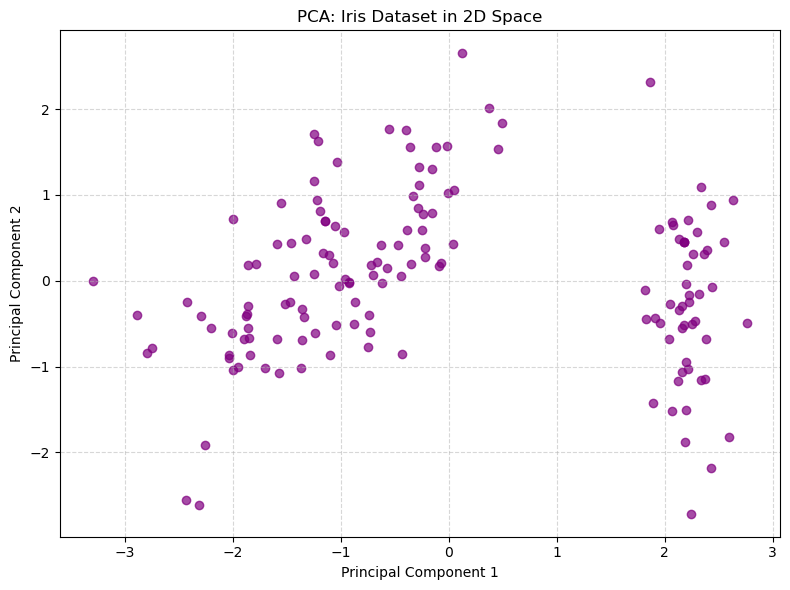


Choose an option:
1. PCA Analysis with Visualization
2. KMeans Clustering with Visualization
3. Exit
Enter 1, 2, or 3: 2

Performing KMeans Clustering...
+-------------+------------+-------------+------------+----------+
|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|prediction|
+-------------+------------+-------------+------------+----------+
|          5.1|         3.5|          1.4|         0.2|         1|
|          4.9|         3.0|          1.4|         0.2|         1|
|          4.7|         3.2|          1.3|         0.2|         1|
|          4.6|         3.1|          1.5|         0.2|         1|
|          5.0|         3.6|          1.4|         0.2|         1|
+-------------+------------+-------------+------------+----------+
only showing top 5 rows



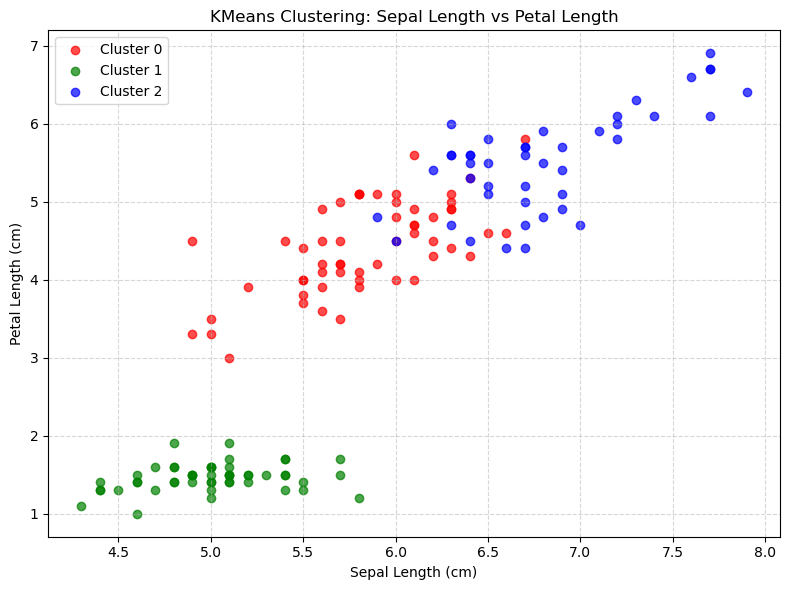


Choose an option:
1. PCA Analysis with Visualization
2. KMeans Clustering with Visualization
3. Exit
Enter 1, 2, or 3: 3
Exiting...


In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler, VectorAssembler, PCA
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("PCA and KMeans on Iris Dataset").getOrCreate()

# Load Iris dataset
file_path = r'Iris.csv'  # Make sure this file exists in your working directory
data = spark.read.csv(file_path, header=True, inferSchema=True)
data.show(5)

# Use actual column names from the dataset
features = data.select('SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm')

# Assemble features into a single vector column
assembler = VectorAssembler(
    inputCols=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'],
    outputCol='features'
)
assembled_data = assembler.transform(features)

# Standardize the features
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

# PCA Function
def pca_analysis():
    print("\nPerforming PCA Analysis...")
    pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
    pca_model = pca.fit(scaled_data)
    pca_result = pca_model.transform(scaled_data)
    pca_result.select('SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'pca_features').show(5)

    # Convert to pandas for visualization
    pca_pd = pca_result.select('pca_features').toPandas()
    pca_pd['PCA1'] = pca_pd['pca_features'].apply(lambda x: float(x[0]))
    pca_pd['PCA2'] = pca_pd['pca_features'].apply(lambda x: float(x[1]))

    # PCA Scatter Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_pd['PCA1'], pca_pd['PCA2'], alpha=0.7, color='purple')
    plt.title('PCA: Iris Dataset in 2D Space')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# KMeans Function
def kmeans_clustering():
    print("\nPerforming KMeans Clustering...")
    kmeans = KMeans(k=3, featuresCol='scaled_features', predictionCol='prediction')
    kmeans_model = kmeans.fit(scaled_data)
    kmeans_result = kmeans_model.transform(scaled_data)
    kmeans_result.select('SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'prediction').show(5)

    # Convert to pandas for visualization
    kmeans_pd = kmeans_result.select('SepalLengthCm', 'PetalLengthCm', 'prediction').toPandas()

    # Cluster Scatter Plot
    plt.figure(figsize=(8, 6))
    colors = ['red', 'green', 'blue']
    for cluster in range(3):
        cluster_data = kmeans_pd[kmeans_pd['prediction'] == cluster]
        plt.scatter(
            cluster_data['SepalLengthCm'],
            cluster_data['PetalLengthCm'],
            color=colors[cluster],
            label=f'Cluster {cluster}',
            alpha=0.7
        )

    plt.title('KMeans Clustering: Sepal Length vs Petal Length')
    plt.xlabel('Sepal Length (cm)')
    plt.ylabel('Petal Length (cm)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# CLI Menu
while True:
    print("\nChoose an option:")
    print("1. PCA Analysis with Visualization")
    print("2. KMeans Clustering with Visualization")
    print("3. Exit")
    choice = input("Enter 1, 2, or 3: ")

    if choice == '1':
        pca_analysis()
    elif choice == '2':
        kmeans_clustering()
    elif choice == '3':
        print("Exiting...")
        break
    else:
        print("Invalid choice, try again.")

spark.stop()
